# imports

In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential

import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import os

# only needed for the process bar addon
from ipywidgets import IntProgress
from IPython.display import display
import time

# these 2 lines fixes some GPU problems I have had.
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# path to dataset
ds_location = 'E:/ML sypnosis/other datasets/UrbanSound8K/audio/'
# path to output 
# it is not used currently in this program | # go to  "Data Augmentation" to see what it was used for
ds_o_loc = 'E:/ML sypnosis/other datasets/UrbanS8K_out/audio/'

import warnings
warnings.filterwarnings('ignore')
print(librosa.__version__)
# ignore this, since this is 100% a problem at "librosa" fault (it is just a wraning)

Using TensorFlow backend.
C:\Users\Ziegler\.conda\envs\tf_gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\Ziegler\.conda\envs\tf_gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


0.7.2


# needed to make the plots of the models

In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [4]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# handle the data

In [5]:
# Read Data
data = pd.read_csv('UrbanSound8K.csv')
data.head(5)

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [6]:
df = data.groupby('class')["class"].nunique()
print(df)

class
air_conditioner     1
car_horn            1
children_playing    1
dog_bark            1
drilling            1
engine_idling       1
gun_shot            1
jackhammer          1
siren               1
street_music        1
Name: class, dtype: int64


In [7]:
data.shape

(8732, 8)

In [8]:
# only get data over 3 seconds long                                                   ("not" limited to 3000)
valid_data = data[['slice_file_name', 'fold' ,'classID', 'class']][ data['end']-data['start'] >= 3 ] #[:3000]
valid_data.shape

(7468, 4)

In [9]:
# Example of a Siren spectrogram
y, sr = librosa.load(ds_location + 'fold6/135160-8-0-0.wav', duration=2.97)

# this is the old line
#ps = librosa.feature.melspectrogram(y=y, hop_length=2048, n_fft=2048, win_length=2048, sr=sr)

# this line gives an output of 32x32
ps = librosa.feature.melspectrogram(
    y=y, 
    sr=sr, 
    S=None, 
    hop_length=2048, 
    n_mels= 32,
    window='hann', 
    center=True, 
    pad_mode='reflect', 
    power=2.0)

print(type(ps))

# the output (32, 32) is (y, x)
print("ps shape:", ps.shape)
# ziegler
print("y, x")
print("y:", len(y))
print("sr:", sr )

<class 'numpy.ndarray'>
ps shape: (32, 32)
y, x
y: 65489
sr: 22050


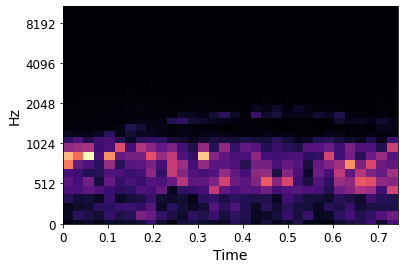

In [10]:
# (log scale mal) spectrogram of siren clip
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [11]:
# Example of a AC spectrogram
y, sr = librosa.load(ds_location + 'fold1/134717-0-0-19.wav', duration=2.97)
ps = librosa.feature.melspectrogram(
    y=y, 
    sr=sr, 
    S=None, 
    hop_length=2048, 
    n_mels= 32,
    window='hann', 
    center=True, 
    pad_mode='reflect', 
    power=2.0)
ps.shape
print("y:", len(y))

y: 65489


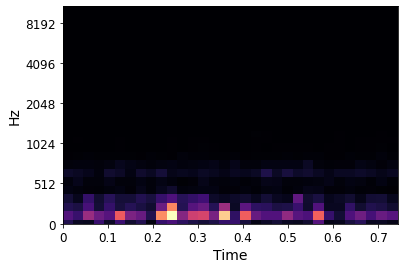

In [12]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [13]:
# Example of a children playing spectrogram
y, sr = librosa.load(ds_location + 'fold9/13579-2-0-16.wav', duration=2.97)
ps = librosa.feature.melspectrogram(
    y=y, 
    sr=sr, 
    S=None, 
    hop_length=2048, 
    n_mels= 32,
    window='hann', 
    center=True, 
    pad_mode='reflect', 
    power=2.0)
ps.shape

(32, 32)

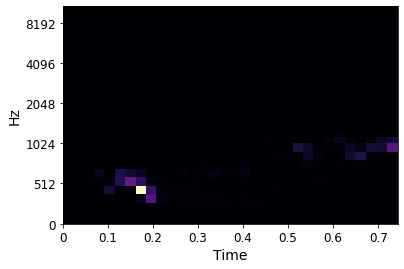

In [14]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [15]:
# Example of a drilling spectrogram
y, sr = librosa.load(ds_location + 'fold9/137815-4-0-0.wav', duration=2.97)
ps = librosa.feature.melspectrogram(
    y=y, 
    sr=sr, 
    S=None, 
    hop_length=2048, 
    n_mels= 32,
    window='hann', 
    center=True, 
    pad_mode='reflect', 
    power=2.0)
ps.shape

(32, 32)

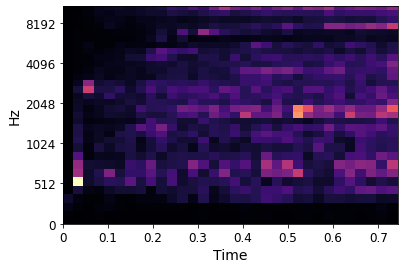

In [16]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

Now lets add a Column to the local version of our dataset  
"folder name" / "file name"  
like this "fold5/100263-2-0-117.wav"  
then we just add the value of "ds_location" in front of it, when we need to reach the file on our local drive

In [17]:
valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype('str')
for i in valid_data:
    print(i)

slice_file_name
fold
classID
class
path


In [18]:
print(valid_data["path"])

1       fold5/100263-2-0-117.wav
2       fold5/100263-2-0-121.wav
3       fold5/100263-2-0-126.wav
4       fold5/100263-2-0-137.wav
5       fold5/100263-2-0-143.wav
                  ...           
8724       fold7/99812-1-0-1.wav
8725       fold7/99812-1-0-2.wav
8726       fold7/99812-1-1-0.wav
8727       fold7/99812-1-2-0.wav
8729       fold7/99812-1-4-0.wav
Name: path, Length: 7468, dtype: object


# now we convert all our sound files into spectrograms with a size of 32x32

In [19]:
D = [] # Dataset

# I changed the size of data we are working with, just to make this script take less time
#max_count = 3000
max_count = 7468

# this values are only needed to sure an addon progress bar # "ipywidgets" and "IPython.display"
f = IntProgress(min=0, max=max_count)
display(f)

testing = valid_data
for row in testing.itertuples():
     
    # here we are making mel spectrogram of each sound file
    # this is done by dividing the (Frequency) into 32 components (from 0 to 22.05 kilohertz)
    # (from 0 to 22.05 kilohertz) is the range of audible sound (humans can only hear up to 20 kilohertz, but close enough)
    
    # our (Time) duration is at 2.97, which is divided into 32 frames of 23 ms.
    # so now we got 32 components acreoss (time) as well
    # so the overall input is a 32x32 matrix of real numbers
    
    y, sr = librosa.load(ds_location + row.path, duration=2.97) 
    
    ps = librosa.feature.melspectrogram(
        y=y, 
        sr=sr, 
        S=None, 
        hop_length=2048, 
        n_mels= 32,
        window='hann', 
        center=True, 
        pad_mode='reflect', 
        power=2.0)
    
    if ps.shape != (32, 32): continue
    D.append( (ps, row.classID) )
    
    # count up the progress bar
    f.value += 1.

IntProgress(value=0, max=7468)

In [20]:
print("Number of samples: ", len(D))

Number of samples:  7467


# making the converted dataset ready for the model

In [21]:
dataset = D
random.shuffle(dataset)

# ------ I resized the size of data we are working with
#train = dataset[:2500] 
#test = dataset[2500:]  

# the normal size of the full dataset
train = dataset[:7000] 
test = dataset[7000:]  

# so now we got 32 components acreoss (time) as well
X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input

# we reshape the input as a 32x32x1 3D matrix (for the CNN input)
X_train = np.array([x.reshape( (32, 32, 1) ) for x in X_train])
X_test = np.array([x.reshape( (32, 32, 1) ) for x in X_test])

# One-Hot encoding for classes

# here we encode the classes with the 10 class-label types
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test = np.array(keras.utils.to_categorical(y_test, 10))

In [22]:
temp = train[:1]
print("train", temp)
print("--------------")
temp = test[:1]
print("test", temp)
print("--------------")
temp = y_train[:1]
print("y_train", temp)
print("--------------")
temp = y_test[:1]
print("y_test", temp)
print("--------------")

train [(array([[5.1238823e+00, 5.4971271e+00, 5.0303979e+00, ..., 6.8860917e+00,
        4.8845663e+00, 5.0629792e+00],
       [4.9817395e-01, 1.3611960e+00, 1.3988012e+00, ..., 2.0949438e+00,
        1.2853495e+00, 7.6506948e-01],
       [2.9211408e-01, 7.2848344e-01, 3.4703571e-01, ..., 4.0940949e-01,
        3.3663702e-01, 1.6836308e-01],
       ...,
       [8.8307923e-03, 7.2138924e-03, 4.5868540e-03, ..., 6.4842094e-04,
        1.4071219e-03, 1.2015303e-03],
       [1.2565642e-02, 4.5337444e-03, 4.0351166e-03, ..., 2.7927058e-03,
        7.2747925e-03, 7.9580266e-03],
       [8.5031595e-03, 4.1910294e-03, 4.2167148e-03, ..., 7.7345077e-04,
        9.9840201e-04, 1.4067793e-03]], dtype=float32), 5)]
--------------
test [(array([[3.67956018e+00, 1.14323711e+00, 6.28216624e-01, ...,
        2.87111342e-01, 1.23120427e-01, 2.11009121e+00],
       [4.49755955e+00, 6.06348455e-01, 1.06830016e-01, ...,
        4.94371504e-01, 4.36982661e-01, 1.07808816e+00],
       [3.45326996e+00, 2.129

# model 1(not in use)

In [23]:
# version 1 # old # best about 0.73 ac 

# model = Sequential()
# input_shape=(32, 32, 1)

# model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
# model.add(MaxPooling2D((4, 2), strides=(4, 2)))
# model.add(Activation('relu'))

# model.add(Conv2D(48, (5, 5), padding="valid"))
# model.add(MaxPooling2D((3, 2), strides=(3, 2)))
# model.add(Activation('relu'))

# model.add(Conv2D(48, (1, 5), padding="valid"))
# model.add(Activation('relu'))

# model.add(Flatten())
# model.add(Dropout(rate=0.5))

# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(rate=0.5))

# model.add(Dense(10))
# model.add(Activation('softmax'))

# setting up the model 2

In [24]:
# version 2 - many layers, low amount of neurons # best about 0.85 ac

input_shape=(32, 32, 1)
model2 = keras.models.Sequential([
    keras.layers.Conv2D(24, 7, activation="relu", padding="same", input_shape=input_shape),
    keras.layers.MaxPooling2D((2)),
    keras.layers.Conv2D(48, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(48, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2)),
    keras.layers.Conv2D(96, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(96, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(48, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(24, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
    ])

# fitting 'model 2' to the dataset and compiling it

In [25]:
dataset = D
random.shuffle(dataset)

#train = dataset[:2500]
#test = dataset[2500:]

train = dataset[:7000]
test = dataset[7000:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

X_train = np.array([x.reshape( (32, 32, 1) ) for x in X_train])
X_test = np.array([x.reshape( (32, 32, 1) ) for x in X_test])

y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test = np.array(keras.utils.to_categorical(y_test, 10))

In [26]:
model2.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

model2.fit(
	x=X_train, 
	y=y_train,
    epochs=80,
    batch_size=32,
    validation_data= (X_test, y_test))

score = model2.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7000 samples, validate on 467 samples
Epoch 1/80
7000/7000 [==============================] - 6s 814us/step - loss: 2.2634 - accuracy: 0.1586 - val_loss: 2.1601 - val_accuracy: 0.2120
Epoch 2/80
7000/7000 [==============================] - 1s 201us/step - loss: 2.1088 - accuracy: 0.2103 - val_loss: 1.9612 - val_accuracy: 0.3212
Epoch 3/80
7000/7000 [==============================] - 1s 203us/step - loss: 2.0055 - accuracy: 0.2354 - val_loss: 1.7975 - val_accuracy: 0.3448
Epoch 4/80
7000/7000 [==============================] - 1s 196us/step - loss: 1.8721 - accuracy: 0.2839 - val_loss: 1.7370 - val_accuracy: 0.4090
Epoch 5/80
7000/7000 [==============================] - 1s 208us/step - loss: 1.7594 - accuracy: 0.3394 - val_loss: 1.6324 - val_accuracy: 0.4283
Epoch 6/80
7000/7000 [==============================] - 1s 208us/step - loss: 1.7117 - accuracy: 0.3587 - val_loss: 1.5352 - val_accuracy: 0.4518
Epoch 7/80
7000/7000 [==============================] - 1s 198us/step - loss:

7000/7000 [==============================] - 1s 207us/step - loss: 0.6458 - accuracy: 0.7693 - val_loss: 1.0039 - val_accuracy: 0.7687
Epoch 57/80
7000/7000 [==============================] - 1s 197us/step - loss: 0.6229 - accuracy: 0.7794 - val_loss: 0.8115 - val_accuracy: 0.8051
Epoch 58/80
7000/7000 [==============================] - 1s 200us/step - loss: 0.5802 - accuracy: 0.7966 - val_loss: 0.9921 - val_accuracy: 0.7859
Epoch 59/80
7000/7000 [==============================] - 1s 208us/step - loss: 0.6645 - accuracy: 0.7731 - val_loss: 1.0410 - val_accuracy: 0.7773
Epoch 60/80
7000/7000 [==============================] - 1s 207us/step - loss: 0.6492 - accuracy: 0.7789 - val_loss: 2.2097 - val_accuracy: 0.8158
Epoch 61/80
7000/7000 [==============================] - 1s 208us/step - loss: 0.6248 - accuracy: 0.7900 - val_loss: 1.0850 - val_accuracy: 0.7730
Epoch 62/80
7000/7000 [==============================] - ETA: 0s - loss: 0.6286 - accuracy: 0.79 - 2s 214us/step - loss: 0.6314 - 

this line is only here, to see if it will make the top model have a scroll bar.

# setting up the model 3 (my best)

In [27]:
# version 3 - many layers, high amount of neurons # best about 0.96 ac
input_shape=(32, 32, 1)
model3 = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=input_shape),
    keras.layers.MaxPooling2D((2)),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2)),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
    ])

printing out types and lengths

In [28]:
print("train", type(train))
print("test", type(test))

print("X_train", type(X_train))
print("X_test", type(X_test))
print("y_train", type(y_train))
print("y_test", type(y_test))
print("------------------------------")

print("train", len(train))
print("test", len(test))

print("X_train", len(X_train))
print("X_test", len(X_test))
print("y_train", len(y_train))
print("y_test", len(y_test))
print("------------------------------")

train <class 'list'>
test <class 'list'>
X_train <class 'numpy.ndarray'>
X_test <class 'numpy.ndarray'>
y_train <class 'numpy.ndarray'>
y_test <class 'numpy.ndarray'>
------------------------------
train 7000
test 467
X_train 7000
X_test 467
y_train 7000
y_test 467
------------------------------


display the structure of the model (it failed)

In [29]:
# this works, but it does not look good or make a lot of sense
#print("model1 summary:", model3.summary())

this next part was me trying to work with a python module that visualize the model, but it gave me so many problems

In [30]:
## import pydot
## import pydotplus
## #import graphviz 

## tf.keras.utils.plot_model(
##     model3
## )

# import pydot as pyd
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# keras.utils.vis_utils.pydot = pyd

# #Visualize Model

# def visualize_model(model3):
#   return SVG(model_to_dot(model3).create(prog='dot', format='svg'))
# #create your model
# #then call the function on your model
# visualize_model(model3)

In [31]:
# import keras
# import pydot as pyd
# from IPython.display import SVG
# ##from keras.utils.vis_utils import model_to_dot

# ##keras.utils.vis_utils.pydot = pyd

# ##Visualize Model

# ## def visualize_model(model):
# ##   return SVG(model_to_dot(model).create(prog='dot', format='svg'))

# ##create your model
# ##then call the function on your model
# SVG(model_to_dot(model3).create(prog='dot', format='svg'))

# fitting 'model 3' to the dataset and compiling it

In [32]:
model3.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

# this model don't really work with epochs at 10, the lowest I would go, would be 50 but I recommend 70
model3.fit(
	x=X_train, 
	y=y_train,
    epochs=80,
    batch_size=32,
    validation_data= (X_test, y_test))

score = model3.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7000 samples, validate on 467 samples
Epoch 1/80
7000/7000 [==============================] - 3s 459us/step - loss: 2.2169 - accuracy: 0.1739 - val_loss: 2.0693 - val_accuracy: 0.2612
Epoch 2/80
7000/7000 [==============================] - 2s 274us/step - loss: 1.9210 - accuracy: 0.2879 - val_loss: 1.7088 - val_accuracy: 0.4133
Epoch 3/80
7000/7000 [==============================] - 2s 265us/step - loss: 1.7009 - accuracy: 0.3670 - val_loss: 1.5438 - val_accuracy: 0.4732
Epoch 4/80
7000/7000 [==============================] - 2s 256us/step - loss: 1.5847 - accuracy: 0.4270 - val_loss: 1.3917 - val_accuracy: 0.4946
Epoch 5/80
7000/7000 [==============================] - 2s 259us/step - loss: 1.4182 - accuracy: 0.4946 - val_loss: 1.3522 - val_accuracy: 0.4882
Epoch 6/80
7000/7000 [==============================] - 2s 258us/step - loss: 1.3155 - accuracy: 0.5366 - val_loss: 1.3836 - val_accuracy: 0.5246
Epoch 7/80
7000/7000 [==============================] - 2s 257us/step - loss:

7000/7000 [==============================] - 2s 258us/step - loss: 0.2121 - accuracy: 0.9399 - val_loss: 1.0769 - val_accuracy: 0.8458
Epoch 57/80
7000/7000 [==============================] - 2s 256us/step - loss: 0.2540 - accuracy: 0.9300 - val_loss: 0.9399 - val_accuracy: 0.8480
Epoch 58/80
7000/7000 [==============================] - 2s 253us/step - loss: 0.2853 - accuracy: 0.9250 - val_loss: 0.9824 - val_accuracy: 0.8415
Epoch 59/80
7000/7000 [==============================] - 2s 254us/step - loss: 0.2934 - accuracy: 0.9341 - val_loss: 0.8571 - val_accuracy: 0.8544
Epoch 60/80
7000/7000 [==============================] - 2s 258us/step - loss: 0.2783 - accuracy: 0.9316 - val_loss: 1.0522 - val_accuracy: 0.8694
Epoch 61/80
7000/7000 [==============================] - 2s 261us/step - loss: 0.2165 - accuracy: 0.9376 - val_loss: 0.8762 - val_accuracy: 0.8737
Epoch 62/80
7000/7000 [==============================] - 2s 254us/step - loss: 0.1301 - accuracy: 0.9584 - val_loss: 1.2147 - val_

We are able to get around $90 - 98\%$ accuracy. Nice!  
Lets see the curve for it

# playing around with a different model structure (model 4)

In [33]:
# testing out something here # 60 epochs was at about 0.95 ac / 80 epochs should do it

# all the neurons are double the size of the last model 
# (you can tell when you run it, since it takes about double the time)

input_shape=(32, 32, 1)
model4 = keras.models.Sequential([
    keras.layers.Conv2D(128, 7, activation="relu", padding="same", input_shape=input_shape),
    keras.layers.MaxPooling2D((2)),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2)),
    keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
    ])

In [34]:
#print("model summary:", model4.summary())

# fitting 'model 4' to the dataset and compiling it

In [35]:
model4.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

model4.fit(
	x=X_train, 
	y=y_train,
    epochs=80,
    batch_size=32,
    validation_data= (X_test, y_test))

score = model4.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7000 samples, validate on 467 samples
Epoch 1/80
7000/7000 [==============================] - 5s 718us/step - loss: 2.1488 - accuracy: 0.2024 - val_loss: 1.9004 - val_accuracy: 0.2719
Epoch 2/80
7000/7000 [==============================] - 4s 501us/step - loss: 1.7224 - accuracy: 0.3650 - val_loss: 1.6524 - val_accuracy: 0.4026
Epoch 3/80
7000/7000 [==============================] - 3s 497us/step - loss: 1.4923 - accuracy: 0.4701 - val_loss: 1.3077 - val_accuracy: 0.5310
Epoch 4/80
7000/7000 [==============================] - 3s 489us/step - loss: 1.3092 - accuracy: 0.5496 - val_loss: 1.4426 - val_accuracy: 0.5503
Epoch 5/80
7000/7000 [==============================] - 3s 487us/step - loss: 1.1922 - accuracy: 0.5869 - val_loss: 1.1226 - val_accuracy: 0.5867
Epoch 6/80
7000/7000 [==============================] - 3s 494us/step - loss: 1.1350 - accuracy: 0.6127 - val_loss: 1.1378 - val_accuracy: 0.6060
Epoch 7/80
7000/7000 [==============================] - 3s 485us/step - loss:

7000/7000 [==============================] - 3s 475us/step - loss: 0.2816 - accuracy: 0.9377 - val_loss: 1.0495 - val_accuracy: 0.8458
Epoch 57/80
7000/7000 [==============================] - 3s 472us/step - loss: 0.4007 - accuracy: 0.9136 - val_loss: 1.1043 - val_accuracy: 0.8308
Epoch 58/80
7000/7000 [==============================] - 3s 483us/step - loss: 0.3240 - accuracy: 0.9317 - val_loss: 0.7873 - val_accuracy: 0.8415
Epoch 59/80
7000/7000 [==============================] - 3s 483us/step - loss: 0.1869 - accuracy: 0.9471 - val_loss: 1.4677 - val_accuracy: 0.7901
Epoch 60/80
7000/7000 [==============================] - 4s 575us/step - loss: 0.2363 - accuracy: 0.9453 - val_loss: 0.8571 - val_accuracy: 0.8437
Epoch 61/80
7000/7000 [==============================] - 4s 608us/step - loss: 0.1497 - accuracy: 0.9610 - val_loss: 0.8366 - val_accuracy: 0.8394
Epoch 62/80
7000/7000 [==============================] - 4s 604us/step - loss: 0.1533 - accuracy: 0.9586 - val_loss: 0.9511 - val_

# plot the curves from model 2

In [36]:
model2.history.params

{'batch_size': 32,
 'epochs': 80,
 'steps': None,
 'samples': 7000,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

Saving figure keras_learning_CNN_v2_curves_plot


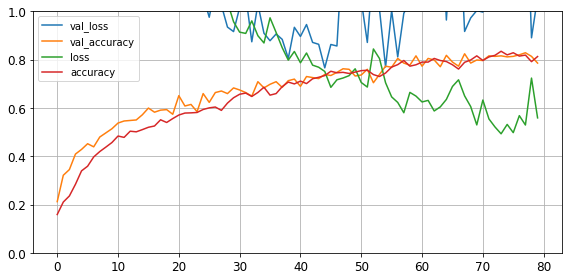

In [37]:
pd.DataFrame(model2.history.history).plot(figsize=(8, 4))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_CNN_v2_curves_plot")
plt.show()

In [38]:
print("model2 summary:", model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 24)        1200      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 48)        10416     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 48)        20784     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 96)          41568     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 96)         

# plot the curves from model 3 

In [39]:
model3.history.params

{'batch_size': 32,
 'epochs': 80,
 'steps': None,
 'samples': 7000,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

Saving figure keras_learning_CNN_v3_curves_plot


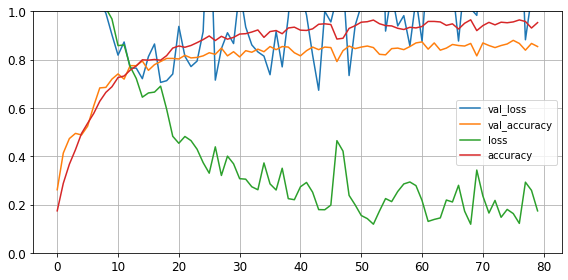

In [40]:
pd.DataFrame(model3.history.history).plot(figsize=(8, 4))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_CNN_v3_curves_plot")
plt.show()

In [41]:
print("model3 summary:", model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        3200      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 256)        

# plot the curves from model 4 

In [42]:
model4.history.params

{'batch_size': 32,
 'epochs': 80,
 'steps': None,
 'samples': 7000,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

Saving figure keras_learning_CNN_v4_curves_plot


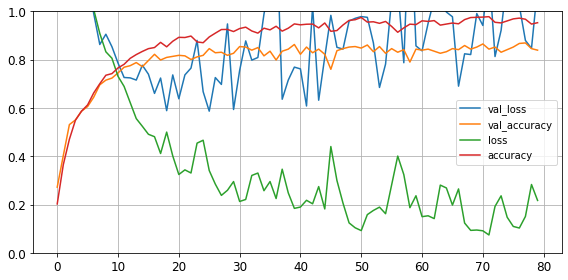

In [43]:
pd.DataFrame(model4.history.history).plot(figsize=(8, 4))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_CNN_v4_curves_plot")
plt.show()

In [44]:
print("model4 summary:", model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 128)       6400      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 512)         1180160   
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 512)        

In [45]:
# next to each other

# everything below here is never used in the program, but it was something I played around with  
# the idea was to change the each sound file's pitch and time, so you could have a dataset of 5x the original size.  
# it works but, I never added them into the local dataset. I didn't need it after I started using CNN

The dataset _would_ consists of:
- 1-7467 normal samples.
- 7468-14934 samples Pitch modulated 2.5 semitones higher.
- 14935-22401 samples Pitch modeulated 2 semitones higher.
- 22402-29869 samples Slowed down to 0.81.
- 29869-37310 samples speed up by 1.07

## Data Augmentation

### 1. Vary Time

In [46]:
# y, sr = librosa.load(ds_location + 'fold1/14113-4-0-1.wav', duration=2.97)
# y_changed = librosa.effects.time_stretch(y, rate=0.81)
# librosa.output.write_wav(ds_o_loc + 'fold1/speed_81/14113-4-0-1.wav' ,y_changed, sr)

In [47]:
# rate = 1.07 # replace with 0.81 and execute again

# f = IntProgress(min=0, max=max_count)
# display(f)

# for row in testing.itertuples():
#     # if the path don't exist, make it 
#     if not os.path.exists(ds_o_loc + 'fold' + str(row.fold) + '/speed_' + str(int(rate*100)) + '/'):
#         os.mkdir(ds_o_loc + 'fold' + str(row.fold) + '/speed_' + str(int(rate*100)) + '/')
    
#     y, sr = librosa.load(ds_location + '/' + row.path)  
#     y_changed = librosa.effects.time_stretch(y, rate=rate)
#     librosa.output.write_wav(ds_o_loc + 'fold' + str(row.fold) + '/speed_' + str(int(rate*100)) + '/' + row.slice_file_name ,y_changed, sr)
    
#     f.value += 1

### 2. Vary pitch

In [48]:
# n_steps = 2 #-1, -2, 2, 1

# f = IntProgress(min=0, max=max_count)
# display(f)


# for row in testing.itertuples():
#     # if the path don't exist, make it 
#     if not os.path.exists(ds_o_loc + 'fold' + str(row.fold) + '/ps1_' + str(int(n_steps)) + '/'):
#         os.mkdir(ds_o_loc + 'fold' + str(row.fold) + '/ps1_' + str(int(n_steps)) + '/')
    
#     y, sr = librosa.load(ds_location + row.path)  
#     y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
#     librosa.output.write_wav(ds_o_loc + 'fold' + str(row.fold) + '/ps1_' + str(int(n_steps)) + '/' + row.slice_file_name ,y_changed, sr)
    
#     f.value += 1

### 3. Change Pitch (PS2)

In [49]:
# n_steps = 2.5 #-2.5, -3.5, 2.5, 3.5

# f = IntProgress(min=0, max=max_count)
# display(f)

# for row in testing.itertuples():
#     # if the path don't exist, make it
#     if not os.path.exists(ds_o_loc + 'fold' + str(row.fold) + '/ps2_m' + str(int(n_steps*10)) + '/'):
#         os.mkdir(ds_o_loc + 'fold' + str(row.fold) + '/ps2_m' + str(int(n_steps*10)) + '/')
    
#     y, sr = librosa.load(ds_location + row.path)  
#     y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
#     librosa.output.write_wav(ds_o_loc + 'fold' + str(row.fold) + '/ps2_m' + str(int(n_steps*10)) + '/' + row.slice_file_name ,y_changed, sr)
#     f.value += 1